# Local RAG agent with LLaMA3.2
We'll combine ideas from paper RAG papers into a RAG agent:

- Routing: Adaptive RAG ([paper](https://arxiv.org/abs/2403.14403)). Route questions to different retrieval approaches
- Fallback: Corrective RAG ([paper](https://arxiv.org/pdf/2401.15884)). Fallback to web search if docs are not relevant to query
- Self-correction: Self-RAG ([paper](https://arxiv.org/abs/2310.11511)). Fix answers w/ hallucinations or don’t address question

In [1]:
import json
import operator
import os
from typing import Annotated, List

import chromadb
from dotenv import load_dotenv
from IPython.display import Image, display
from langchain.schema import Document
from langchain_chroma import Chroma
from langchain_community.document_loaders import PDFPlumberLoader
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_core.messages import HumanMessage, SystemMessage
from langchain_ollama import ChatOllama, OllamaEmbeddings
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langgraph.graph import END, StateGraph
from typing_extensions import TypedDict

load_dotenv("../../.env.research")

True

In [4]:
client = chromadb.HttpClient(host="localhost", port=int(os.getenv("CHROMA_PORT")))
client.delete_collection(os.getenv("CHROMA_COLLECTION_NAME"))

In [2]:
### LLM
local_llm = "llama3.2"
llm = ChatOllama(model=local_llm, temperature=0.1)
llm_json_mode = ChatOllama(model=local_llm, temperature=0, format="json")

In [3]:
def load_pdfs_from_directory(directory_path):
    all_documents = []
    for filename in os.listdir(directory_path):
        if filename.endswith(".pdf"):
            file_path = os.path.join(directory_path, filename)
            loader = PDFPlumberLoader(file_path=file_path)
            documents = loader.load()
            all_documents.extend(documents)
    return all_documents

In [5]:
client = chromadb.HttpClient(
    host=os.getenv("CHROMA_HOST"), port=int(os.getenv("CHROMA_PORT"))
)
vectorstore = None
if os.getenv("CHROMA_COLLECTION_NAME") not in [
    collection.name for collection in client.list_collections()
]:
    client.create_collection(os.getenv("CHROMA_COLLECTION_NAME"))
    pdf_docs = load_pdfs_from_directory(os.getenv("DATA_DIR"))
    text_splitter = RecursiveCharacterTextSplitter(chunk_size=1500, chunk_overlap=200)
    all_splits = text_splitter.split_documents(pdf_docs)
    vectorstore = Chroma.from_documents(
        documents=all_splits,
        embedding=OllamaEmbeddings(model="nomic-embed-text"),
        collection_name=os.getenv("CHROMA_COLLECTION_NAME"),
        client=client,
    )
else:
    vectorstore = Chroma(
        collection_name=os.getenv("CHROMA_COLLECTION_NAME"),
        client=client,
        embedding_function=OllamaEmbeddings(model="nomic-embed-text"),
    )

retriever = vectorstore.as_retriever(search_kwargs={"k": 3})

## Components

In [6]:
### Router

# Prompt
router_instructions = """You are a routing assistant that determines the best data source to answer user questions. There are three options:

Vectorstore: Use this for **specific and detailed questions** about the rules, setup, or gameplay of Rummikub.
Websearch: Use this for **recent changes to Rummikub rules**, **current events**, or information explicitly marked as being **outside the scope** of the vectorstore.
Irrelevant: Use this for **questions unrelated to Rummikub**, including general questions about unrelated topics, technologies, or concepts or uncertain questions.

**Output Format:**
Respond strictly in the following JSON format:

{"datasource": "<vectorstore | websearch | irrelevant>"}

**Guidelines:**
1. Use `vectorstore` **only** for questions directly referencing Rummikub rules, setup, or gameplay. Examples:
   - "What are the rules for forming sets in Rummikub?"
   - "How many tiles does each player start with?"
2. Use `websearch` **only** for questions requiring external research or recent updates about Rummikub. Examples:
   - "Who is the current world champion of Rummikub?"
   - "Have there been recent changes to Rummikub rules?"
3. Use `irrelevant` for all other questions, including general knowledge or unrelated topics. Examples:
   - "What are the main causes of global warming?"
   - "What are the types of agent memory?"

Always prioritize the most accurate category.
"""

# Test router

test_web_search = llm_json_mode.invoke(
    [SystemMessage(content=router_instructions)]
    + [HumanMessage(content="Who is the world champion of Rummikub?")]
)

test_none = llm_json_mode.invoke(
    [SystemMessage(content=router_instructions)]
    + [HumanMessage(content="What is Chain of thought prompting?")]
)

test_vectorstore = llm_json_mode.invoke(
    [SystemMessage(content=router_instructions)]
    + [HumanMessage(content="How many tiles does each player start with in rummikub?")]
)
print(
    json.loads(test_web_search.content),
    json.loads(test_none.content),
    json.loads(test_vectorstore.content),
)

{'datasource': 'websearch'} {'datasource': 'irrelevant'} {'datasource': 'vectorstore'}


In [7]:
### Retrieval Grader

# Doc grader instructions
doc_grader_instructions = """You are a grader assessing relevance of a retrieved document to a user question.

If the document contains keyword(s) or semantic meaning related to the question, grade it as relevant."""

# Grader prompt
doc_grader_prompt = """Here is the retrieved document: \n\n {document} \n\n Here is the user question: \n\n {question}.

This carefully and objectively assess whether the document contains at least some information that is relevant to the question.

Return JSON with single key, binary_score, that is 'yes' or 'no' score to indicate whether the document contains at least some information that is relevant to the question."""

# Test
question = "How many tiles does each player start with in rummikub?"
docs = retriever.invoke(question)
doc_txt = docs[1].page_content
doc_grader_prompt_formatted = doc_grader_prompt.format(
    document=doc_txt, question=question
)
result = llm_json_mode.invoke(
    [SystemMessage(content=doc_grader_instructions)]
    + [HumanMessage(content=doc_grader_prompt_formatted)]
)
json.loads(result.content)

{'binary_score': 'no'}

In [8]:
### Generate

# Prompt
rag_prompt = """You are an assistant for question-answering tasks.

Here is the context to use to answer the question:

{context}

Carefully analyze the context above.

Now, review the user question:

{question}

Provide a clear, direct, and concise answer to the user's question, using only the information from the context. Avoid repeating long excerpts from the context verbatim unless necessary to clarify your response.

Make sure the answer is well-structured, easy to understand, and directly addresses the user's query.

Answer:"""


# Post-processing
def format_docs(docs):
    return "\n\n".join(doc.page_content for doc in docs)


# Test
docs = retriever.invoke(question)
docs_txt = format_docs(docs)
rag_prompt_formatted = rag_prompt.format(context=docs_txt, question=question)
generation = llm.invoke([HumanMessage(content=rag_prompt_formatted)])
print(generation.content)

Each player starts with 14 tiles in Rummikub.


In [9]:
### Hallucination Grader

# Hallucination grader instructions
hallucination_grader_instructions = """

You are a teacher grading a quiz.

You will be given FACTS and a STUDENT ANSWER.

Here is the grade criteria to follow:

(1) Ensure the STUDENT ANSWER is grounded in the FACTS.

(2) Ensure the STUDENT ANSWER does not contain "hallucinated" information outside the scope of the FACTS.

Score:

A score of yes means that the student's answer meets all of the criteria. This is the highest (best) score.

A score of no means that the student's answer does not meet all of the criteria. This is the lowest possible score you can give.
"""

# Grader prompt
hallucination_grader_prompt = """FACTS: \n\n {documents} \n\n STUDENT ANSWER: {generation}.

Return JSON with one key, binary_score is 'yes' or 'no' score to indicate whether the STUDENT ANSWER is grounded in the FACTS."""

# Test using documents and generation from above
hallucination_grader_prompt_formatted = hallucination_grader_prompt.format(
    documents=docs_txt, generation=generation.content
)
result = llm_json_mode.invoke(
    [SystemMessage(content=hallucination_grader_instructions)]
    + [HumanMessage(content=hallucination_grader_prompt_formatted)]
)
json.loads(result.content)

{'binary_score': 'yes'}

In [10]:
### Answer Grader

# Answer grader instructions
answer_grader_instructions = """You are a teacher grading a quiz.

You will be given a QUESTION and a STUDENT ANSWER.

Here is the grade criteria to follow:

(1) The STUDENT ANSWER helps to answer the QUESTION

Score:

A score of yes means that the student's answer meets all of the criteria. This is the highest (best) score.

The student can receive a score of yes if the answer contains extra information that is not explicitly asked for in the question.

A score of no means that the student's answer does not meet all of the criteria. This is the lowest possible score you can give.
"""

# Grader prompt
answer_grader_prompt = """QUESTION: \n\n {question} \n\n STUDENT ANSWER: {generation}.

Return JSON with one key, binary_score is 'yes' or 'no' score to indicate whether the STUDENT ANSWER meets the criteria."""

# Test
question_yes = "What happens when a player cannot make a valid move in Rummikub?"
answer_yes = "If a player cannot make a valid move, they must draw a tile from the pool. If they still cannot play, their turn ends, and the game proceeds to the next player."

# Test using question and generation from above, it should return a score of yes
answer_grader_prompt_formatted = answer_grader_prompt.format(
    question=question_yes, generation=answer_yes
)
result = llm_json_mode.invoke(
    [SystemMessage(content=answer_grader_instructions)]
    + [HumanMessage(content=answer_grader_prompt_formatted)]
)
print(json.loads(result.content))

# Test using question and generation from above, it should return a score of no
question_no = "What is the purpose of the joker tile in Rummikub?"
answer_no = "The joker tile is removed from the game before it begins."

answer_grader_prompt_formatted = answer_grader_prompt.format(
    question=question_no, generation=answer_no
)

result = llm_json_mode.invoke(
    [SystemMessage(content=answer_grader_instructions)]
    + [HumanMessage(content=answer_grader_prompt_formatted)]
)

print(json.loads(result.content))

{'binary_score': 'yes'}
{'binary_score': 'no'}


In [11]:
web_search_tool = TavilySearchResults(max_results=3)

## Graph state
The graph state schema contains keys that we want to:

- Pass to each node in our graph
- Optionally, modify in each node of our graph
See conceptual docs [here](https://langchain-ai.github.io/langgraph/concepts/low_level/#state).

In [12]:
class GraphState(TypedDict):
    """
    Graph state is a dictionary that contains information we want to propagate to, and modify in, each graph node.
    """

    question: str  # User question
    generation: str  # LLM generation
    web_search: str  # Binary decision to run web search
    max_retries: int  # Max number of retries for answer generation
    answers: int  # Number of answers generated
    loop_step: Annotated[int, operator.add]
    documents: List[str]  # List of retrieved documents

Each node in our graph is simply a function that:

(1) Take `state` as an input

(2) Modifies `state`

(3) Write the modified state to the state schema (dict)

See conceptual docs [here](https://langchain-ai.github.io/langgraph/concepts/low_level/#nodes).

Each edge routes between nodes in the graph.

See conceptual docs [here](https://langchain-ai.github.io/langgraph/concepts/low_level/#edges).

In [13]:
### Nodes


def retrieve(state):
    """
    Retrieve documents from vectorstore

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): New key added to state, documents, that contains retrieved documents
    """
    print("---RETRIEVE---")
    question = state["question"]

    # Write retrieved documents to documents key in state
    documents = retriever.invoke(question)
    return {"documents": documents}


def handle_irrelevant(state):
    """
    Handle irrelevant questions

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): New key added to state, generation, that contains response to irrelevant question
    """
    print("---HANDLE IRRELEVANT---")
    return {
        "generation": "This question is not related to the Rummikub rules. Please ask something specific to the game."
    }


def generate(state):
    """
    Generate answer using RAG on retrieved documents

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): New key added to state, generation, that contains LLM generation
    """
    print("---GENERATE---")
    question = state["question"]
    documents = state["documents"]
    loop_step = state.get("loop_step", 0)

    # RAG generation
    docs_txt = format_docs(documents)
    rag_prompt_formatted = rag_prompt.format(context=docs_txt, question=question)
    generation = llm.invoke([HumanMessage(content=rag_prompt_formatted)])
    return {"generation": generation, "loop_step": loop_step + 1}


def grade_documents(state):
    """
    Determines whether the retrieved documents are relevant to the question
    If any document is not relevant, we will set a flag to run web search

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): Filtered out irrelevant documents and updated web_search state
    """

    print("---CHECK DOCUMENT RELEVANCE TO QUESTION---")
    question = state["question"]
    documents = state["documents"]

    # Score each doc
    filtered_docs = []
    web_search = "No"
    for d in documents:
        doc_grader_prompt_formatted = doc_grader_prompt.format(
            document=d.page_content, question=question
        )
        result = llm_json_mode.invoke(
            [SystemMessage(content=doc_grader_instructions)]
            + [HumanMessage(content=doc_grader_prompt_formatted)]
        )
        grade = json.loads(result.content)["binary_score"]
        # Document relevant
        if grade.lower() == "yes":
            print("---GRADE: DOCUMENT RELEVANT---")
            filtered_docs.append(d)
        # Document not relevant
        else:
            print("---GRADE: DOCUMENT NOT RELEVANT---")
            # We do not include the document in filtered_docs
            continue

    if len(filtered_docs) == 0:
        # We set a flag to indicate that we want to run web search only if all documents are irrelevant
        web_search = "Yes"
    return {"documents": filtered_docs, "web_search": web_search}


def web_search(state):
    """
    Web search based on the question

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): Appended web results to documents
    """

    print("---WEB SEARCH---")
    question = state["question"]
    documents = state.get("documents", [])

    # Web search
    docs = web_search_tool.invoke({"query": question})
    web_results = "\n".join([d["content"] for d in docs])
    web_results = Document(page_content=web_results)
    documents.append(web_results)
    return {"documents": documents}


### Edges


def route_question(state):
    """
    Route question to web search or RAG or none

    Args:
        state (dict): The current graph state

    Returns:
        str: Next node to call
    """

    print("---ROUTE QUESTION---")
    route_question = llm_json_mode.invoke(
        [SystemMessage(content=router_instructions)]
        + [HumanMessage(content=state["question"])]
    )
    source = json.loads(route_question.content)["datasource"]
    if source == "websearch":
        print("---ROUTE QUESTION TO WEB SEARCH---")
        return "websearch"
    elif source == "vectorstore":
        print("---ROUTE QUESTION TO RAG---")
        return "vectorstore"
    elif source == "irrelevant":
        print("---ROUTE QUESTION TO IRRELEVANT---")
        return "irrelevant"


def decide_to_generate(state):
    """
    Determines whether to generate an answer, or add web search

    Args:
        state (dict): The current graph state

    Returns:
        str: Binary decision for next node to call
    """

    print("---ASSESS GRADED DOCUMENTS---")
    web_search = state["web_search"]

    if web_search == "Yes":
        # All documents have been filtered check_relevance
        # We will re-generate a new query
        print(
            "---DECISION: NOT ALL DOCUMENTS ARE RELEVANT TO QUESTION, INCLUDE WEB SEARCH---"
        )
        return "websearch"
    else:
        # We have relevant documents, so generate answer
        print("---DECISION: GENERATE---")
        return "generate"


def grade_generation_v_documents_and_question(state):
    """
    Determines whether the generation is grounded in the document and answers question

    Args:
        state (dict): The current graph state

    Returns:
        str: Decision for next node to call
    """

    print("---CHECK HALLUCINATIONS---")
    question = state["question"]
    documents = state["documents"]
    generation = state["generation"]
    max_retries = state.get("max_retries", 3)  # Default to 3 if not provided

    hallucination_grader_prompt_formatted = hallucination_grader_prompt.format(
        documents=format_docs(documents), generation=generation.content
    )
    result = llm_json_mode.invoke(
        [SystemMessage(content=hallucination_grader_instructions)]
        + [HumanMessage(content=hallucination_grader_prompt_formatted)]
    )
    grade = json.loads(result.content)["binary_score"]

    # Check hallucination
    if grade == "yes":
        print("---DECISION: GENERATION IS GROUNDED IN DOCUMENTS---")
        # Check question-answering
        print("---GRADE GENERATION vs QUESTION---")
        # Test using question and generation from above
        answer_grader_prompt_formatted = answer_grader_prompt.format(
            question=question, generation=generation.content
        )
        result = llm_json_mode.invoke(
            [SystemMessage(content=answer_grader_instructions)]
            + [HumanMessage(content=answer_grader_prompt_formatted)]
        )
        grade = json.loads(result.content)["binary_score"]
        if grade == "yes":
            print("---DECISION: GENERATION ADDRESSES QUESTION---")
            return "useful"
        elif state["loop_step"] <= max_retries:
            print("---DECISION: GENERATION DOES NOT ADDRESS QUESTION---")
            return "not useful"
        else:
            print("---DECISION: MAX RETRIES REACHED---")
            return "max retries"
    elif state["loop_step"] <= max_retries:
        print("---DECISION: GENERATION IS NOT GROUNDED IN DOCUMENTS, RE-TRY---")
        return "not supported"
    else:
        print("---DECISION: MAX RETRIES REACHED---")
        return "max retries"

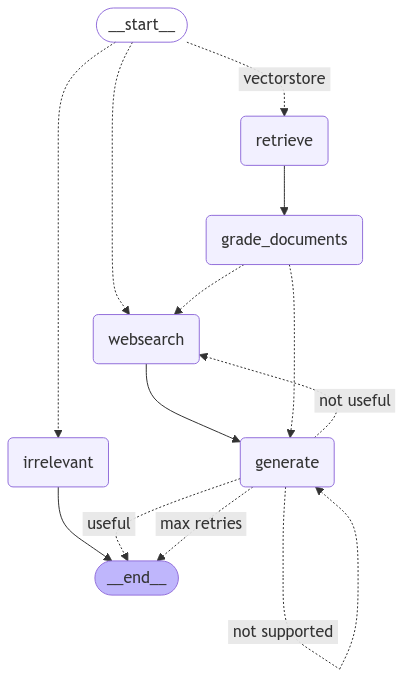

In [14]:
workflow = StateGraph(GraphState)

# Define the nodes
workflow.add_node("websearch", web_search)  # web search
workflow.add_node("retrieve", retrieve)  # retrieve
workflow.add_node("irrelevant", handle_irrelevant)  # handle irrelevant
workflow.add_node("grade_documents", grade_documents)  # grade documents
workflow.add_node("generate", generate)  # generate

# Build graph
workflow.set_conditional_entry_point(
    route_question,
    {
        "websearch": "websearch",
        "vectorstore": "retrieve",
        "irrelevant": "irrelevant",
    },
)
workflow.add_edge("websearch", "generate")
workflow.add_edge("retrieve", "grade_documents")
workflow.add_conditional_edges(
    "grade_documents",
    decide_to_generate,
    {
        "websearch": "websearch",
        "generate": "generate",
    },
)
workflow.add_conditional_edges(
    "generate",
    grade_generation_v_documents_and_question,
    {
        "not supported": "generate",
        "useful": END,
        "not useful": "websearch",
        "max retries": END,
    },
)

# Set irrelevant as end node
workflow.add_edge("irrelevant", END)

# Compile
graph = workflow.compile()
display(Image(graph.get_graph().draw_mermaid_png()))

In [15]:
inputs = {
    "question": "What are the models released today for llama3.2?",
    "max_retries": 3,
}
for event in graph.stream(inputs, stream_mode="values"):
    print(event)

---ROUTE QUESTION---
---ROUTE QUESTION TO IRRELEVANT---
{'question': 'What are the models released today for llama3.2?', 'max_retries': 3, 'loop_step': 0}
---HANDLE IRRELEVANT---
{'question': 'What are the models released today for llama3.2?', 'generation': 'This question is not related to the Rummikub rules. Please ask something specific to the game.', 'max_retries': 3, 'loop_step': 0}


In [ ]:
inputs = {
    "question": "What is the purpose of the joker tile in Rummikub?",
    "max_retries": 3,
}
for event in graph.stream(inputs, stream_mode="values"):
    print(event)

---ROUTE QUESTION---
---ROUTE QUESTION TO RAG---
{'question': 'What is the purpose of the joker tile in Rummikub?', 'max_retries': 3, 'loop_step': 0}
---RETRIEVE---
{'question': 'What is the purpose of the joker tile in Rummikub?', 'max_retries': 3, 'loop_step': 0, 'documents': [Document(metadata={'CreationDate': "D:20241118154334+01'00'", 'Creator': 'Adobe Acrobat Pro (32-bit) 24.4.20272', 'ModDate': "D:20241123190612+01'00'", 'Producer': 'Adobe Acrobat Pro (32-bit) 24.4.20272', 'Title': '2600-0236-0041 080719_rummikub rules', 'file_path': '../../data\\rummikub_rules.pdf', 'page': 2, 'source': '../../data\\rummikub_rules.pdf', 'total_pages': 13}, page_content='2. Tiles on rack Tiles on table\n1 7 2 3 5 6\nThe player splits the run\nand clears the joker. 1 2 3 5 6 7 clear\n3. Tiles on rack Tiles on table\n5 6 7\nThe player adds the blue 5 5 6 7 clear\nand clears the joker.'), Document(metadata={'CreationDate': "D:20241118154334+01'00'", 'Creator': 'Adobe Acrobat Pro (32-bit) 24.4.20272

In [35]:
inputs = {"question": "Is there a Rummikub championship?", "max_retries": 3}
for event in graph.stream(inputs, stream_mode="values"):
    print(event)

---ROUTE QUESTION---
---ROUTE QUESTION TO WEB SEARCH---
{'question': 'Is there a Rummikub championship?', 'max_retries': 3, 'loop_step': 0}
---WEB SEARCH---
{'question': 'Is there a Rummikub championship?', 'max_retries': 3, 'loop_step': 0, 'documents': [Document(metadata={}, page_content='Are There Rummikub Tournaments? Are There Rummikub Tournaments? 1 When was the first Rummikub tournament? 2 Rummikub tournaments 4 Rummikub Tournament Rules 6 The Joker in the Rummikub tournament So are there Rummikub tournaments? Rummikub is a professional game that has tournaments to see who is the best in the world every three years. When was the first Rummikub tournament? When the creator of the Rummikub game, Ephraim sadly passed away at the age of 75, it motivated his children to set in motion the first Rummikub Championship tournament. Rummikub tournaments Rummikub Tournament Rules The Joker in the Rummikub tournament If a joker is still on a player’s rack at the finishing point of the tournam

In [36]:
inputs = {
    "question": "What is the purpose of the joker tile in Rummikub?",
    "max_retries": 3,
}

# Execute the graph synchronously (no streaming)
final_state = graph.invoke(inputs)

print(final_state["generation"].content)

---ROUTE QUESTION---
---ROUTE QUESTION TO RAG---
---RETRIEVE---
---CHECK DOCUMENT RELEVANCE TO QUESTION---
---GRADE: DOCUMENT NOT RELEVANT---
---GRADE: DOCUMENT RELEVANT---
---GRADE: DOCUMENT RELEVANT---
---ASSESS GRADED DOCUMENTS---
---DECISION: GENERATE---
---GENERATE---
---CHECK HALLUCINATIONS---
---DECISION: GENERATION IS GROUNDED IN DOCUMENTS---
---GRADE GENERATION vs QUESTION---
---DECISION: GENERATION ADDRESSES QUESTION---
The joker tile in Rummikub can be used as a substitute for any numbered tile of any color to make up a valid combination.


## Conclusion
I think the rag is working fine. Only a bit slow but that is I think due to resources (I only have cpu). I need to check with the dev ops team to see if we can deploy the Graph.